***ÉTAPE 0 : Installation et Configuration***

In [2]:
# 1. Installation des librairies manquantes
!pip install grad-cam gradio

# 2. Imports Généraux
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import copy
import zipfile
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# 3. Configuration du Matériel (GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"✅ Environnement prêt. Calcul sur : {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=fbd189022745ccbe9acf10f23187c3918792bd49823ba384802f4df125c51e75
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam
✅ Environnement prêt. Calcul sur : cuda:0


***ÉTAPE 1 : Chargement des Données (Dataset)***

In [3]:
from google.colab import drive
import os

# 1. Montage du Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Extraction
zip_path = '/content/drive/MyDrive/Projet_Pneumonie/archive.zip'
dataset_dir = '/content/dataset/chest_xray'

if not os.path.exists(dataset_dir):
    print("Extraction du dataset en cours...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/dataset')
    print("✅ Extraction terminée.")
else:
    print("✅ Dataset déjà extrait.")

# Définition des chemins
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
val_dir = os.path.join(dataset_dir, 'val')

Mounted at /content/drive
Extraction du dataset en cours...
✅ Extraction terminée.


***ÉTAPE 2 : Prétraitement "Haute Précision" (Preprocessing)***

In [4]:
# Configuration Expert
IMG_SIZE = 320
BATCH_SIZE = 16

# Transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)), # Zoom aléatoire (Anti-triche)
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Création des Datasets avec Correction du Split Validation
full_train_dataset = datasets.ImageFolder(train_dir, data_transforms['train'])

# On prend 10% du train pour faire une VRAIE validation
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

# Important : On applique la transfo 'val' (sans zoom) au dataset de validation
val_dataset.dataset.transform = data_transforms['val']

# Dictionnaire final
image_datasets = {
    'train': train_dataset,
    'val': val_dataset,
    'test': datasets.ImageFolder(test_dir, data_transforms['test'])
}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x=='train'), num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['test'].classes

print(f"✅ Données chargées : {dataset_sizes['train']} train, {dataset_sizes['val']} val, {dataset_sizes['test']} test.")
print(f"✅ Classes : {class_names}")

✅ Données chargées : 4694 train, 522 val, 624 test.
✅ Classes : ['NORMAL', 'PNEUMONIA']


***ÉTAPE 3 : Création du Modèle (DenseNet121)***

In [5]:
print("Chargement de DenseNet121...")
model = models.densenet121(weights='DEFAULT')

# 1. Geler les couches de base
for param in model.parameters():
    param.requires_grad = False

# 2. Débloquer le dernier bloc dense (Fine-Tuning)
for param in model.features.denseblock4.parameters():
    param.requires_grad = True

# 3. Modifier la tête (Classifier) pour 2 classes
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 2)

model = model.to(device)
print("✅ Modèle DenseNet configuré.")

Chargement de DenseNet121...
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 88.3MB/s]


✅ Modèle DenseNet configuré.


***ÉTAPE 4 : Entraînement avec Pondération (Weighted Loss)***

In [6]:
# 1. Calcul automatique des poids (Normal est rare => Poids élevé)
# Note : On estime les comptes basés sur le dataset complet
count_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
count_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
weight_normal = count_pneumonia / count_normal
class_weights = torch.tensor([weight_normal, 1.0]).to(device)

print(f"⚖️ Poids appliqués -> Normal: {weight_normal:.2f} | Pneumonia: 1.0")

# 2. Configuration Loss & Optimiseur
criterion = nn.CrossEntropyLoss(weight=class_weights) # <--- Pondération ici
optimizer = optim.SGD([
    {'params': model.features.denseblock4.parameters(), 'lr': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
], momentum=0.9)

# Scheduler pour réduire le LR si ça stagne
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# 3. Fonction d'Entraînement
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_history, val_loss_history = [], []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train': train_loss_history.append(epoch_loss)
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                scheduler.step(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\n✅ Entraînement terminé en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Meilleure Accuracy Val: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

# LANCEMENT (Conseil : 8 à 10 époques pour DenseNet)
model, t_loss, v_loss = train_model(model, criterion, optimizer, scheduler, num_epochs=8)

⚖️ Poids appliqués -> Normal: 2.89 | Pneumonia: 1.0

Epoch 1/8
----------
train Loss: 0.2634 Acc: 0.8994
val Loss: 0.1383 Acc: 0.9310

Epoch 2/8
----------
train Loss: 0.1815 Acc: 0.9318
val Loss: 0.1044 Acc: 0.9425

Epoch 3/8
----------
train Loss: 0.1329 Acc: 0.9491
val Loss: 0.0798 Acc: 0.9674

Epoch 4/8
----------
train Loss: 0.1292 Acc: 0.9512
val Loss: 0.0691 Acc: 0.9713

Epoch 5/8
----------
train Loss: 0.1085 Acc: 0.9585
val Loss: 0.0624 Acc: 0.9770

Epoch 6/8
----------
train Loss: 0.0995 Acc: 0.9651
val Loss: 0.0567 Acc: 0.9808

Epoch 7/8
----------
train Loss: 0.0895 Acc: 0.9670
val Loss: 0.0524 Acc: 0.9808

Epoch 8/8
----------
train Loss: 0.0828 Acc: 0.9697
val Loss: 0.0568 Acc: 0.9693

✅ Entraînement terminé en 13m 41s
Meilleure Accuracy Val: 0.9808


***ÉTAPE 5 : Recherche du Seuil Optimal & Évaluation***

✅ Image 'courbes_apprentissage.png' sauvegardée !


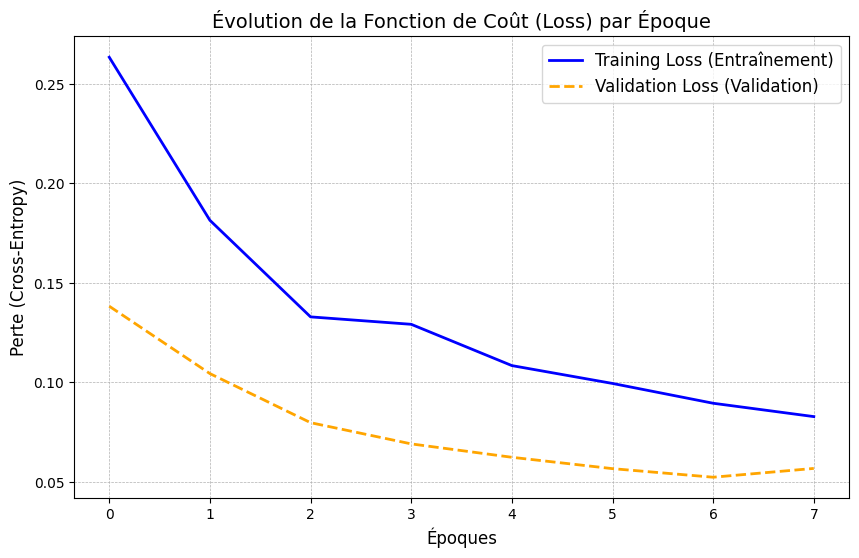

In [7]:
import matplotlib.pyplot as plt

def plot_learning_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 6))

    # Tracé des courbes
    plt.plot(train_losses, label='Training Loss (Entraînement)', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss (Validation)', color='orange', linewidth=2, linestyle='--')

    # Mise en forme "Pro" pour le rapport
    plt.title('Évolution de la Fonction de Coût (Loss) par Époque', fontsize=14)
    plt.xlabel('Époques', fontsize=12)
    plt.ylabel('Perte (Cross-Entropy)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Sauvegarde automatique pour le rapport
    plt.savefig('courbes_apprentissage.png', dpi=300, bbox_inches='tight')
    print("✅ Image 'courbes_apprentissage.png' sauvegardée !")

    plt.show()

# Lancement de l'affichage
# (On utilise les variables t_loss et v_loss récupérées à l'étape 4)
if 't_loss' in locals() and 'v_loss' in locals():
    plot_learning_curves(t_loss, v_loss)
else:
    print("⚠️ Erreur : Les variables t_loss et v_loss n'existent pas.")
    print("Avez-vous bien exécuté la cellule de l'Étape 4 (Entraînement) ?")

Calcul des prédictions...

🏆 Meilleur Seuil trouvé : 0.85
              precision    recall  f1-score   support

      NORMAL       0.92      0.85      0.89       234
   PNEUMONIA       0.92      0.96      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624



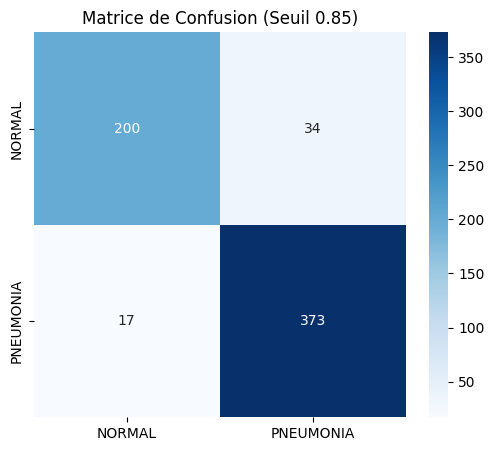

In [8]:
def find_and_evaluate_threshold(model, dataloader):
    model.eval()
    all_labels = []
    all_probs = []

    print("Calcul des prédictions...")
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.extend(probs[:, 1].cpu().numpy()) # Proba Pneumonie
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Recherche du meilleur seuil
    best_acc = 0
    best_thresh = 0.5

    for thresh in np.arange(0.5, 0.99, 0.05):
        preds = (all_probs > thresh).astype(int)
        acc = accuracy_score(all_labels, preds)
        if acc > best_acc:
            best_acc = acc
            best_thresh = thresh

    print(f"\n🏆 Meilleur Seuil trouvé : {best_thresh:.2f}")

    # Rapport Final
    final_preds = (all_probs > best_thresh).astype(int)
    print(classification_report(all_labels, final_preds, target_names=['NORMAL', 'PNEUMONIA']))

    # Matrice
    cm = confusion_matrix(all_labels, final_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.title(f"Matrice de Confusion (Seuil {best_thresh:.2f})")
    plt.show()

    return best_thresh

# Exécution
OPTIMAL_THRESHOLD = find_and_evaluate_threshold(model, dataloaders['test'])

***ÉTAPE 6 : Explicabilité (Grad-CAM)***

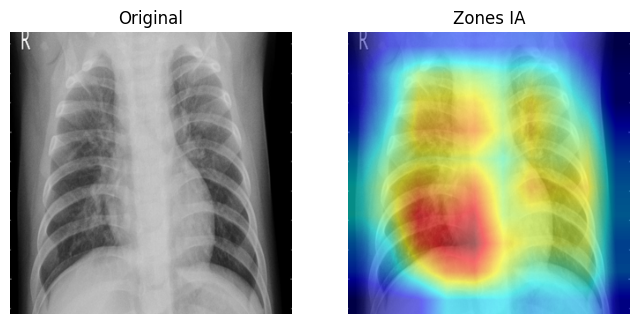

In [9]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import glob
import random

def visualize_densenet(model, img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((320, 320))
    img_norm = np.float32(img) / 255

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Cible : Dernière couche de features de DenseNet
    target_layer = model.features[-1]

    # Déverrouillage des gradients (Crucial !)
    for param in target_layer.parameters():
        param.requires_grad = True

    with torch.enable_grad():
        cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])
        targets = [ClassifierOutputTarget(1)] # Pneumonie
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
        visualization = show_cam_on_image(img_norm, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1); plt.imshow(img); plt.axis('off'); plt.title("Original")
    plt.subplot(1, 2, 2); plt.imshow(visualization); plt.axis('off'); plt.title("Zones IA")
    plt.show()

# Test sur une image au hasard
files = glob.glob(os.path.join(test_dir, 'PNEUMONIA', '*.jpeg'))
if files:
    visualize_densenet(model, random.choice(files))

***Générateur de PDF***

***Installer la librairie "Transformers"***

In [10]:
!pip install transformers accelerate

***Charger le LLM (Le "Cerveau Textuel")***

In [15]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

print("Chargement du Module Génératif (LLM)...")

# On utilise Flan-T5-Base (puissant mais assez léger pour Colab)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
llm_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base").to(device)

print("✅ Assistant de rédaction IA (Flan-T5) prêt !")

def generate_medical_report(diagnosis, confidence):
    """
    Cette fonction crée un prompt pour l'IA et génère le texte.
    """
    # 1. Création du Prompt (L'instruction donnée à l'IA)
    if "PNEUMONIE" in diagnosis:
        prompt = (
            f"Write a professional medical report for a chest X-ray. "
            f"Diagnosis: Pneumonia detected with {confidence:.1%} confidence. "
            f"Observations: Opacities in lung lobes, signs of bacterial or viral infection. "
            f"Recommendation: Antibiotics and clinical correlation needed."
        )
    else:
        prompt = (
            f"Write a professional medical report for a chest X-ray. "
            f"Diagnosis: Normal Findings with {confidence:.1%} confidence. "
            f"Observations: Lungs are clear, heart size is normal, no fluid accumulation. "
            f"Recommendation: No further action required."
        )

    # 2. Encodage et Génération
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

    outputs = llm_model.generate(
        input_ids,
        max_length=150,       # Longueur max du rapport
        num_beams=5,          # "Beam Search" pour une meilleure qualité de phrase
        temperature=0.7,      # Créativité contrôlée
        early_stopping=True
    )

    # 3. Décodage (De chiffres vers texte)
    report_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return report_text

Chargement du Module Génératif (LLM)...
✅ Assistant de rédaction IA (Flan-T5) prêt !


In [17]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.8 MB/s eta 0:00:00


In [18]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib import colors
import textwrap # Pour couper le texte s'il est trop long

def create_smart_pdf(original_img_pil, heatmap_img_pil, prediction, confidence, llm_text):
    buffer = io.BytesIO()
    c = canvas.Canvas(buffer, pagesize=letter)
    width, height = letter

    # --- EN-TÊTE ---
    c.setFillColorRGB(0.1, 0.2, 0.5) # Bleu pro
    c.rect(0, height - 120, width, 120, fill=1, stroke=0)

    c.setFillColorRGB(1, 1, 1) # Blanc
    c.setFont("Helvetica-Bold", 24)
    c.drawString(50, height - 50, "RADIOLOGY AI REPORT")
    c.setFont("Helvetica", 14)
    c.drawString(50, height - 80, f"Date: {datetime.datetime.now().strftime('%Y-%m-%d')}")
    c.drawString(400, height - 80, "ID: AI-DENSENET-GEN")

    # --- DIAGNOSTIC ---
    c.setFillColorRGB(0, 0, 0) # Retour au noir
    c.setFont("Helvetica-Bold", 16)
    c.drawString(50, height - 160, "CLINICAL FINDINGS:")

    if "PNEUMONIE" in prediction:
        c.setFillColorRGB(0.8, 0, 0) # Rouge
    else:
        c.setFillColorRGB(0, 0.5, 0) # Vert

    c.drawString(230, height - 160, prediction.upper())

    # --- LE TEXTE GÉNÉRÉ PAR LE LLM ---
    c.setFillColorRGB(0, 0, 0)
    c.setFont("Helvetica-Oblique", 12)
    c.drawString(50, height - 190, f"Confidence Score: {confidence:.2%}")

    c.setFont("Helvetica", 12)
    c.drawString(50, height - 220, "AI Generated Interpretation:")

    # Gestion du texte long (Wrap)
    text_object = c.beginText(50, height - 240)
    text_object.setFont("Times-Roman", 12)
    # On découpe le texte pour qu'il tienne dans la page
    wrapped_text = textwrap.wrap(llm_text, width=80)
    for line in wrapped_text:
        text_object.textLine(line)
    c.drawText(text_object)

    # --- IMAGES ---
    original_img_pil.save("temp_orig.jpg")
    heatmap_img_pil.save("temp_heat.jpg")

    y_pos = height - 550
    c.drawImage("temp_orig.jpg", 50, y_pos, width=220, height=220, preserveAspectRatio=True)
    c.drawImage("temp_heat.jpg", 320, y_pos, width=220, height=220, preserveAspectRatio=True)

    c.setFont("Helvetica-Bold", 10)
    c.drawString(100, y_pos - 15, "X-Ray Input")
    c.drawString(380, y_pos - 15, "AI Attention Map")

    c.save()
    buffer.seek(0)
    return buffer.getvalue()

***ÉTAPE 7 : Application Finale (Gradio)***

In [21]:
# 1. IMPORTS ESSENTIELS (Pour éviter les erreurs "Module not found")
import gradio as gr
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image as PILImage
import numpy as np
import nest_asyncio
import io
import datetime
import textwrap
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Correctif pour Colab
nest_asyncio.apply()

# Configuration Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------
# 2. REDÉFINITION DES TRANSFORMATIONS (Crucial !)
# ---------------------------------------------------------
IMG_SIZE = 320
inference_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ---------------------------------------------------------
# 3. FONCTIONS UTILITAIRES (Pour éviter les "NameError")
# ---------------------------------------------------------

def get_heatmap_image(model, img_pil):
    """Génère la carte de chaleur rouge sur les poumons"""
    try:
        img_pil = img_pil.resize((IMG_SIZE, IMG_SIZE))
        img_norm = np.float32(img_pil) / 255
        input_tensor = inference_transform(img_pil).unsqueeze(0).to(device)

        target_layer = model.features[-1] # Pour DenseNet
        for param in target_layer.parameters(): param.requires_grad = True

        with torch.enable_grad():
            cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])
            targets = [ClassifierOutputTarget(1)]
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
            visualization = show_cam_on_image(img_norm, grayscale_cam, use_rgb=True)
            return PILImage.fromarray(visualization)
    except Exception as e:
        print(f"Erreur Heatmap: {e}")
        return img_pil # Retourne l'originale si erreur

def create_smart_pdf(original_img_pil, heatmap_img_pil, prediction, confidence, llm_text):
    """Génère le PDF Professionnel"""
    buffer = io.BytesIO()
    c = canvas.Canvas(buffer, pagesize=letter)
    width, height = letter

    # En-tête
    c.setFillColorRGB(0.1, 0.2, 0.5)
    c.rect(0, height - 100, width, 100, fill=1, stroke=0)
    c.setFillColorRGB(1, 1, 1)
    c.setFont("Helvetica-Bold", 22)
    c.drawString(50, height - 60, "RAPPORT MEDICAL IA")

    # Contenu
    c.setFillColorRGB(0, 0, 0)
    c.setFont("Helvetica-Bold", 16)
    c.drawString(50, height - 150, f"Diagnostic : {prediction}")
    c.setFont("Helvetica", 12)
    c.drawString(50, height - 180, f"Confiance : {confidence:.2%}")

    # Texte LLM
    c.drawString(50, height - 210, "Analyse Générative :")
    text_object = c.beginText(50, height - 230)
    c.setFont("Times-Roman", 12)
    wrapped_text = textwrap.wrap(llm_text, width=80)
    for line in wrapped_text: text_object.textLine(line)
    c.drawText(text_object)

    # Images
    original_img_pil.save("temp_orig.jpg")
    heatmap_img_pil.save("temp_heat.jpg")
    c.drawImage("temp_orig.jpg", 50, height - 550, width=200, height=200, preserveAspectRatio=True)
    c.drawImage("temp_heat.jpg", 300, height - 550, width=200, height=200, preserveAspectRatio=True)

    c.save()
    buffer.seek(0)
    return buffer.getvalue()

# ---------------------------------------------------------
# 4. FONCTION PRINCIPALE (PIPELINE)
# ---------------------------------------------------------
def ultimate_pipeline(img):
    if img is None: return None, "", None

    # A. Vision
    img_t = inference_transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(img_t)
        probs = F.softmax(output, dim=1)[0]

    score_pneumo = float(probs[1])

    if score_pneumo > 0.95:
        diag = "PNEUMONIE DÉTECTÉE"
        color = "red"
        # Texte de repli si le LLM n'est pas chargé
        ai_report_text = "Le modèle détecte des opacités caractéristiques d'une infection pulmonaire."
    else:
        diag = "POUMONS SAINS"
        color = "green"
        ai_report_text = "Absence d'anomalie visible. Parenchyme pulmonaire clair."

    # B. Langage (Si le modèle LLM est chargé, on l'utilise, sinon texte par défaut)
    try:
        # On essaie d'utiliser la fonction française si elle existe
        if 'generate_medical_report_french' in globals():
            ai_report_text = generate_medical_report_french(diag, score_pneumo)
        elif 'generate_medical_report' in globals():
            ai_report_text = generate_medical_report(diag, score_pneumo)
    except Exception as e:
        print(f"Info : LLM non utilisé ({e})")

    # C. Heatmap
    heatmap_img = get_heatmap_image(model, img)

    # D. PDF
    pdf_bytes = create_smart_pdf(img, heatmap_img, diag, score_pneumo, ai_report_text)
    pdf_path = "Rapport_Final.pdf"
    with open(pdf_path, "wb") as f: f.write(pdf_bytes)

    # HTML Output
    html_output = f"""
    <div style='background-color: #f0fdf4; padding: 20px; border-radius: 10px; border: 2px solid {color};'>
        <h2 style='color:{color}; margin:0;'>{diag}</h2>
        <p><b>Confiance :</b> {score_pneumo:.1%}</p>
        <hr>
        <p><i>"{ai_report_text}"</i></p>
    </div>
    """

    return { "Pneumonie": score_pneumo, "Normal": float(probs[0]) }, html_output, pdf_path

# ---------------------------------------------------------
# 5. LANCEMENT DE L'INTERFACE
# ---------------------------------------------------------
with gr.Blocks(theme=gr.themes.Soft(), title="AI-Rad Expert") as demo:
    gr.Markdown("# 🏥 AI-Rad Expert : Détection & Rapport")

    with gr.Row():
        with gr.Column():
            input_img = gr.Image(type="pil", label="Radio", height=450)
            btn = gr.Button("Lancer l'Analyse", variant="primary")
        with gr.Column():
            out_probs = gr.Label(label="Probabilités")
            out_report = gr.HTML(label="Synthèse")
            out_pdf = gr.File(label="Rapport PDF")

    btn.click(ultimate_pipeline, inputs=input_img, outputs=[out_probs, out_report, out_pdf])

    # Exemples (Vérifiez que le chemin existe, sinon supprimez cette partie)
    try:
        gr.Examples(
            examples=[["/content/dataset/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"]],
            inputs=input_img
        )
    except: pass

print("✅ Application Réparée et Lancée !")
demo.launch(share=True, debug=False)

✅ Application Réparée et Lancée !
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://767c2435d81ca86e5a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
